# Example: Understanding Maximum Flow Calculations in a Bipartite Graph using the Ford-Fulkerson Algorithm
In this example you'll build a flow network from a workers→tasks edgelist, compute the maximum flow using the Ford–Fulkerson algorithm, and experiment with edge capacities to see how bottlenecks form and move.

> __Scenario:__ Suppose we are allocating workers to tasks, and then tracking task completion. We can model this as a flow network where workers are sources, tasks are sinks, and edges represent the capacity of each worker-task assignment. This is similar to our shortest path problem, but we are now reimagining this as a flow problem.

We'll visualize capacities and flows, then run a couple of targeted changes (increase a capacity, then block a node) to observe how assignments and total flow respond.

So let's go!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, and more. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

In [3]:
include(joinpath(@__DIR__, "Include.jl"));

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl), check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Constants
Let's define some constants that will be used throughout the notebook. See the comment for a description of each constant, what it represents, its value, units, and more.

In [6]:
# We are going to plot the path through a graph, so let's provide the coordinates for each node (the layout)
# This layout looks like our schematic but you can rearrange this if you want!
node_coordinates = [

    # source node (you)
    10.0 10.0 ; # 1 source node s (x,y) coordinates

    # people nodes (workers)
    11.0 11.0 ; # 2 people node (x,y) coordinates
    11.0 10.0 ; # 3 people node (x,y) coordinates
    11.0 9.0 ; # 4 people node (x,y) coordinates

    # job nodes (tasks)
    12.0 11.0 ; # 5 job node (x,y) coordinates
    12.0 10.0 ; # 6 job node (x,y) coordinates
    12.0 9.0 ; # 7 job node (x,y) coordinates
    12.0 8.0 ; # 8 job node (x,y) coordinates

    # sink nodes (targets, tasks done!)
    13.0 11.0 ; # 9 sink node t (x,y) coordinates
    13.0 10.0 ; # 10 sink node t (x,y) coordinates
    13.0 9.0 ; # 11 sink node t (x,y) coordinates
    13.0 8.0 ; # 12 sink node t (x,y) coordinates
    
    14.0 10.0 ; # 13 end node (x,y) coordinates
];

## Task 1: Build a task allocation graph model
Let's return to the task allocation problem, but with a twist. You're still node `1` (the source node, manager, etc.). We have a small bipartite graph setup: worker nodes connected to task nodes, where we need to allocate workers to tasks. In other words, we need to find a __flow__ through the network, and in particular we'll find the __maximum flow__.

> __Twist:__ Not every worker can do every task. For example, they don't have the proper training, or perhaps they are on vacation. Thus, in this case instead of thinking about the edge weight, let's think about maximizing the capacity of the assignment. We want every worker assigned to tasks such that we use all of our workers' capacity.

The problem graph edges are stored in `data/Workers-Tasks-Bipartite.edgelist` with fields: 

> __Records__: Each record in our edgelist file has the comma separated fields: `source,` `target,` `cost,` `lb capacity,` `ub capacity`. The `source` field is the id for the source node, for example `1`, the `target` field is the target node id, the `cost` is the cost of assigning the source node to the target node, the `lb capacity` is the lower bound capacity for the edge, and the `ub capacity` is the upper bound capacity for the edge.

In this activity, we'll ignore the edge weight (set to `1`), and instead will focus on the capacity constraints. Now let's set up our edge parser __callback function__:

In [8]:
"""
    function edgerecordparser(record::String, delim::Char=',') -> Tuple{Int, Int, Float64} | Nothing

This method is called to parse a single edge record from the edgelist file. It gets called once for each record in the file. 
The function splits the record into fields based on the specified delimiter and extracts the source node, target node, and cost (weight) of the edge. 
It returns a tuple containing these values. If the record does not have the expected number of fields, it returns `nothing`.

### Arguments
- `record`: The edge record string to parse.
- `delim`: The delimiter used to split the record.

### Returns
- A tuple containing the source node, target node, and cost of the edge, or `nothing` if the record is invalid.
"""
function edgerecordparser(record::String, delim::Char=',')
    
    # record (five fields)
    # source, target, cost, lb, ub

    @show record

    fields = split(record, delim) # this assumes a record of the form "source,target,weight"
    if length(fields) < 5 # we have 5 fields
        return nothing
    end

    # get my data from the line -
    source = parse(Int, fields[1]) # source id
    target = parse(Int, fields[2]) # target id
    cost = parse(Float64, fields[3]) # edge weight
    l = parse(Float64, fields[4]) # lower bound capacity
    u = parse(Float64, fields[5]) # upper bound capacity

    # return a tuple -
    return (source, target, cost, l, u)
end;

Next, let's set the path to the edge list file in the `path_to_edge_file::String` variable:

In [10]:
# TODO: uncomment and set the correct path to the data file
# TODO: If you have your own edgelist file, you can point to that instead of the example file
path_to_edge_file = joinpath(_PATH_TO_DATA, "Workers-Tasks-Bipartite.edgelist") # this points to the graph shown above

"/Users/jeffreyvarner/Desktop/julia_work/CHEME-5800-Fall-2025/CHEME-5800-Labs-Fall-2025/labs/week-5/L5b/data/Workers-Tasks-Bipartite.edgelist"

Next, construct a dictionary [of `MyConstrainedGraphEdgeModel` instances](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyConstrainedGraphEdgeModel) which stores the data for the edges. Let's save our edge models in the `myedgemodels::Dict{Int64, MyConstrainedGraphEdgeModel}` dictionary.

The keys in the edge dictionary will be the edge ids (which we can assume are unique), and the values will be the corresponding `MyConstrainedGraphEdgeModel` instances. Here, we've used the line index in the edgefile as the edge id.

In [12]:
# TODO: uncomment the next line after setting the path to your edge file
# TODO: Behind the scenes, the edgerecordparser function is called to parse each line of the edge file
myedgemodels = MyConstrainedGraphEdgeModels(path_to_edge_file, edgerecordparser, delim=',', comment='#')

record = "1,2,1,0,1"
record = "1,3,1,0,1"
record = "1,4,1,0,1"
record = "5,9,1,0,1"
record = "6,10,1,0,1"
record = "7,11,1,0,1"
record = "8,12,1,0,1"
record = "9,13,1,0,1"
record = "10,13,1,0,1"
record = "11,13,1,0,1"
record = "12,13,1,0,1"
record = "2,5,1,0,1"
record = "2,6,1,0,1"
record = "2,7,1,0,1"
record = "2,8,1,0,1"
record = "3,5,1,0,1"
record = "3,6,1,0,1"
record = "3,7,1,0,1"
record = "3,8,1,0,1"
record = "4,5,1,0,1"
record = "4,6,1,0,1"
record = "4,7,1,0,1"
record = "4,8,1,0,1"


Dict{Int64, MyConstrainedGraphEdgeModel} with 23 entries:
  5  => MyConstrainedGraphEdgeModel(5, 7, 11, 1.0, 0.0, 1.0)
  16 => MyConstrainedGraphEdgeModel(16, 3, 6, 1.0, 0.0, 1.0)
  20 => MyConstrainedGraphEdgeModel(20, 4, 6, 1.0, 0.0, 1.0)
  12 => MyConstrainedGraphEdgeModel(12, 2, 6, 1.0, 0.0, 1.0)
  8  => MyConstrainedGraphEdgeModel(8, 10, 13, 1.0, 0.0, 1.0)
  17 => MyConstrainedGraphEdgeModel(17, 3, 7, 1.0, 0.0, 1.0)
  1  => MyConstrainedGraphEdgeModel(1, 1, 3, 1.0, 0.0, 1.0)
  19 => MyConstrainedGraphEdgeModel(19, 4, 5, 1.0, 0.0, 1.0)
  0  => MyConstrainedGraphEdgeModel(0, 1, 2, 1.0, 0.0, 1.0)
  22 => MyConstrainedGraphEdgeModel(22, 4, 8, 1.0, 0.0, 1.0)
  6  => MyConstrainedGraphEdgeModel(6, 8, 12, 1.0, 0.0, 1.0)
  11 => MyConstrainedGraphEdgeModel(11, 2, 5, 1.0, 0.0, 1.0)
  9  => MyConstrainedGraphEdgeModel(9, 11, 13, 1.0, 0.0, 1.0)
  14 => MyConstrainedGraphEdgeModel(14, 2, 8, 1.0, 0.0, 1.0)
  3  => MyConstrainedGraphEdgeModel(3, 5, 9, 1.0, 0.0, 1.0)
  7  => MyConstrainedGraphEd

Finally, we can build a graph instance. Since this is a directed graph, we'll construct [a `MyDirectedBipartiteGraphModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyDirectedBipartiteGraphModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). Let's save our graph model in the `directedgraphmodel::MyDirectedBipartiteGraphModel` variable.

In [14]:
myedgemodels[1] |> m-> typeof(m) |> T -> fieldnames(T)

(:id, :source, :target, :weight, :lower, :upper)

In [15]:
myedgemodels[1].upper

1.0

In [16]:
directedgraphmodel = let

    # initialize -
    s = 1; # what is the source node
    t = 13; # what is the sink node

    # call the build method to create the graph model
    model = build(MyDirectedBipartiteGraphModel, (
        s = s, # source index
        t = t, # sink index
        edges = myedgemodels
    ));

    
    model # return the model 
end;

**Let's explore the graph model structure.** What's in [a `MyDirectedBipartiteGraphModel` object](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MySimpleDirectedGraphModel)? We can always answer these types of questions by examining the fields of the object type [using the `typeof(...)` function](https://docs.julialang.org/en/v1/base/base/#Core.typeof) in combination with [the `fieldnames(...)` function](https://docs.julialang.org/en/v1/base/base/#Base.fieldnames).

> __Why do we inspect the fields of a type?__ We need to get the type of the instance we want to inspect because fields are associated with a type, not the instance itself. Thus, we always use `typeof(...)` to get the type, and then `fieldnames(...)` to get the fields of that type.

So what is contained in a directed graph model:

In [18]:
typeof(directedgraphmodel) |> T -> fieldnames(T) # We get the type T, then we get the field names of T

(:nodes, :edges, :children, :edgesinverse, :left, :right, :source, :sink, :capacity)

In [19]:
# TODO: Let's look at some of the data structures inside the directedgraphmodel
directedgraphmodel.children

Dict{Int64, Set{Int64}} with 13 entries:
  5  => Set([9])
  12 => Set([13])
  8  => Set([12])
  1  => Set([4, 2, 3])
  6  => Set([10])
  11 => Set([13])
  9  => Set([13])
  3  => Set([5, 6, 7, 8])
  7  => Set([11])
  4  => Set([5, 6, 7, 8])
  13 => Set()
  2  => Set([5, 6, 7, 8])
  10 => Set([13])

The code block below shows how we visualized the flow network. The nodes in the graph are represented as circles, while the edges are represented as lines connecting these circles. Flow in this case goes from a source node ($s$, or node 1) to a sink node ($t$ or node 13). The numbers above the edges represent the __capacity__ of the edge (upper bound on the flow through the edge).

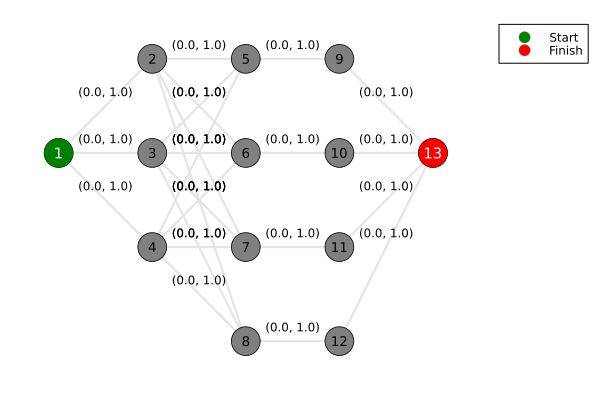

In [21]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go

    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        
        # add weight annotation to edges -
        mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        c = round.(base_graphmodel.capacity[(s,t)], digits=2) # changed to capacity from edges
        annotate!(mx, my + 0.15, text(string(c), 8, :black))
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Finish")

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

**Understanding the graph structure:** This is an _unbalanced_ bipartite-like graph (it has an extra layer before the sink node). The nodes represent different entities in the flow network, while the edges represent the capacity for flow between these entities.

* __Source:__ The green source node ($s$, or node 1) represents the starting point of the flow. Suppose this node represents your wishes. The capacity of the edge $(s,v)$ leaving this node is the _upper bound_ on the flow through edge $(s,v)$. For example, the maximum number of tasks you believe node $v$ is able to do.
* __Intermediate:__ The intermediate nodes represent processing points where flow can be split or combined.
Suppose nodes $(2,3,4)$ represent different workers, while nodes $(5,6,7,8)$ represent different tasks that need to be accomplished. When there is non-zero flow between nodes $(u,v)$, for example between worker $u$ and task $v$, it indicates that worker $u$ is assigned to task $v$. The final layer of nodes $(9,10,11,12)$ represents the completion of these tasks. If no flow is present, it means that the worker is not assigned to the task, or they were unable to complete it.
* __Sink:__ The red sink node ($t$, or node 13) represents the endpoint of the flow or a completion state. For example, the overall set of tasks that have been completed.

We've imagined this graph to represent workers and tasks, but it could also represent raw materials to products, products to suppliers, and suppliers to consumers. This type of bipartite graph is commonly used in supply chain management, workflow optimization, and similar applications.

## Task 2: Compute the maximum flow through the default network
In this task, we'll compute maximum flow through the network using the Ford-Fulkerson method. We've implemented the Ford-Fulkerson algorithm in [the `maximumflow(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/graphs/#VLDataScienceMachineLearningPackage.maximumflow). This function takes a few arguments:
* __graph model__: The graph model representing the flow network. In our case this model will be the `directedgraphmodel::MyDirectedBipartiteGraphModel` instance we created above. 
* __source__ and __sink__ nodes: we need to pass in the node models at which we want to start (source) and where we want to end (sink). In both cases, these are [instances of the `MyGraphNodeModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyGraphNodeModel).
* __algorithm__: Finally, we have a keyword `algorithm` argument that allows us to specify the algorithm we want to use for computing the maximum flow. In our case, we will use the Ford-Fulkerson method. We have also implemented the Edmonds-Karp algorithm as an alternative.

This method returns the maximum flow in the `m::Number` variable, and an edge flow dictionary `flow::Dict{Tuple{Int,Int}, Number}` that contains the flow values for each edge specified by a $(u,v)$ tuple in the graph.

In [24]:
(m,flow) = let

    # initialize -
    s = 1; # we start at node 1
    t = 13; # we end at node 13

    # TODO: uncomment the algorithm you want to use
    algorithm = FordFulkersonAlgorithm(); # which algorithm to use {FordFulkerson, EdmondsKarp}
    # algorithm = EdmondsKarpAlgorithm(); # which algorithm to use {FordFulkerson, EdmondsKarp}

    # TODO: call the maximum flow method with the chosen algorithm
    m,flow = maximumflow(directedgraphmodel, directedgraphmodel.nodes[s], 
        directedgraphmodel.nodes[t], algorithm = algorithm)

    # return -
    m,flow
end;

In [25]:
# TODO: what is in the flow dictionary (or m value)?
flow

Dict{Tuple{Int64, Int64}, Float64} with 12 entries:
  (1, 2)   => 1.0
  (6, 10)  => 1.0
  (3, 7)   => 1.0
  (8, 12)  => 1.0
  (12, 13) => 1.0
  (1, 3)   => 1.0
  (1, 4)   => 1.0
  (2, 6)   => 1.0
  (11, 13) => 1.0
  (4, 8)   => 1.0
  (10, 13) => 1.0
  (7, 11)  => 1.0

The code block below shows how we visualized flow through the graph. The red lines represent the flow paths from the source to the sink, where the amount of flow through each edge is shown above the edge.

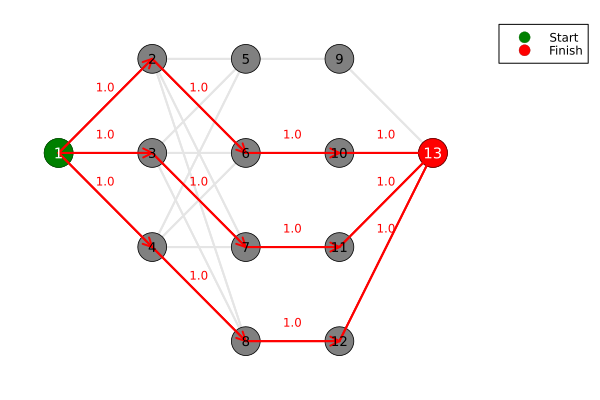

In [27]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go
    path_edges = keys(flow); # this is a dictionary of (u,v) → flow_value
    capacity = base_graphmodel.capacity; # get the capacity dictionary
    flow_dictionary = flow;

    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Finish")

    # plot the flow path -
    for ((s,t),flow_value) ∈ flow_dictionary
       
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=2, label="")
        
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(flow_dictionary[(s,t)], digits=2)
        annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

### Analysis of the default solution
The default maximum flow matches person $2\Longrightarrow 6$, person $3\Longrightarrow 7$ and person $4\Longrightarrow 8$. Wow! That is pretty cool. But wait a minute, what about task $5$ (this does not seem to be assigned to anyone)?

> __Capacity:__ Node $1$ (you) has an out-degree of three, where each edge has a capacity of $1$. Thus, we can allocate (at most) three tasks. 
>
> __Why is this the case?__ The flow through the internal nodes (not source or sink nodes) is limited by the capacities of the edges leading into and out of them, and must be balanced (in = out). For example, if we give node $3$ only one unit of flow, it can only do one job.

What happens if we experiment with the capacities of the edges? Let's increase the capacity of edge $(1,3)$ to `2` and see how it affects the maximum flow, and then set some of the edge capacities to `0` to block flow.

## Task 3: Analyze the effect of changing edge capacities
In this task, let's experiment with the capacity of an edge leaving node $1$, for example edge $e=(1,3)$ and then block some internal edges and see what happens.

> __What do we expect?__ If edge $(1,3)$ is a bottleneck, increasing its capacity should allow more flow through node 3 and may increase the overall maximum flow, but only if downstream edges also have room. If those downstream capacities are already tight, boosting $(1,3)$ won't change the total flow. We're going to test both scenarios.

We'll update the capacities of the `directedgraphmodel::MyDirectedBipartiteGraphModel`, and then re-run the maximum flow algorithm. Let's save the results for this case in the `m₁::Float64`, `flow₁::Dict{Tuple{Int64,Int64},Float64}` and `model₁::MyDirectedBipartiteGraphModel` variables.

In [84]:
(m₁, flow₁, model₁) = let

    # initialize -
    s = 1; # we start at node 1
    t = 13; # we end at node 13
    # algorithm = FordFulkersonAlgorithm(); # which algorithm to use {FordFulkerson, EdmondsKarp}
    algorithm = EdmondsKarpAlgorithm(); # which algorithm to use {FordFulkerson, EdmondsKarp}

    # Stage 1:  Update the capacity -
    model = deepcopy(directedgraphmodel);  # make a copy of the directed graph model

    # TODO: Experiment with the capacities and see what happens
    # TODO: increase the capacity of the edges leaving node 1
    for e ∈ model.edges

        (u,v) = e[1]; # get the (u,v) pair

        if u == 1 && v == 3 # update edge (1,3)
            (lower, upper) = model.capacity[(u,v)]; # get the (upper, lower) capacity for edge (1,3)
            model.capacity[(u,v)] = (lower, 4*upper); # create new bounds
        end

        # TODO: Decrease the capacity of the edges *leaving* node 3
        if (u == 2)
            (lower, upper) = model.capacity[(u,v)]; # get the (upper, lower) capacity
            model.capacity[(u,v)] = (1.0, 2.0); # TODO: What could this correspond to in real life?
        end
    end

    model.capacity[(1,2)] = (1.0,1.0); # hard code nz lower bound

    # Stage 2: Compute the maximum flow with updated capacities -
    m,flow = maximumflow(model, model.nodes[s], model.nodes[t], algorithm = algorithm)

    # return -
    m,flow,model
end;

In [31]:
model₁.capacity[(1,2)]

(1.0, 1.0)

In [82]:
flow₁[(1,2)]

LoadError: KeyError: key (1, 2) not found

The code block below shows how we visualized flow through the __modified__ graph where we increased the capacity of edge $(1,3)$ to `2`. The red lines represent the flow paths from the source to the sink, where the amount of flow through each edge is shown above the edge.

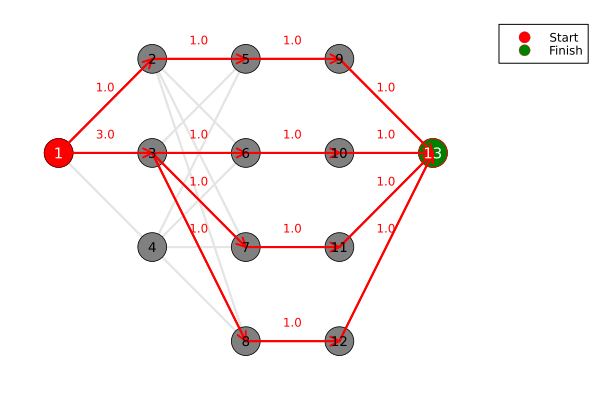

In [86]:
let

    # initialize -
    capacity = model₁.capacity; # get the capacity dictionary
    flow_dictionary = flow₁;
    base_graphmodel = model₁;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go
    path_edges = keys(flow); # this is a dictionary of (u,v) → flow_value
 
    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:red, 
             label="Finish")

    # plot the flow path -
    for ((s,t),flow_value) ∈ flow_dictionary
       
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=2, label="")
        
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(flow_dictionary[(s,t)], digits=2)
        annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

After increasing the capacity of edge $(1,3)$, [the `maximumflow(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/graphs/#VLDataScienceMachineLearningPackage.maximumflow) may route additional units of flow through node 3 if the downstream edges can handle it. 

In the visualization you'll see extra red flow edges leaving node 3 when the change had an effect, and the reported maximum flow value will increase accordingly. 

If the downstream edges are saturated, the plotted flows and total max value will remain unchanged, that tells us node 3 wasn't the overall bottleneck.


#### Block
Next, let's block some of the edges and see what happens. For example, a worker is on vacation and can't do any tasks, or a machine is down. In this case, suppose we have a capacity for edge $(1,3)$ of `2`, but we __block__ all outflow from node `3`. In other words, the edges $\texttt{capacity}(3,\star) = 0$.

> __What do we expect:__ Blocking all outflow from node 3 will remove those routing options entirely. If some flow in the original solution used node 3, [the `maximumflow(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/graphs/#VLDataScienceMachineLearningPackage.maximumflow) must reroute through other workers/tasks or the total maximum flow will drop. The exact change depends on alternative paths and their capacities.

We'll update the capacities of the `directedgraphmodel::MyDirectedBipartiteGraphModel`, and then re-run the maximum flow algorithm. Let's save the results for this case in the `m₂::Float64`, `flow₂::Dict{Tuple{Int64,Int64},Float64}` and `model₂::MyDirectedBipartiteGraphModel` variables.

In [64]:
(m₂, flow₂, model₂) = let

    # initialize -
    s = 1; # we start at node 1
    t = 13; # we end at node 13
    algorithm = FordFulkersonAlgorithm(); # which algorithm to use {FordFulkerson, EdmondsKarp}

    # Stage 1:  Update the capacity -
    model = deepcopy(directedgraphmodel);  # make a copy of the directed graph model

    # increase the capacity of the edges leaving node 1
    for e ∈ model.edges

        (u,v) = e[1]; # get the (u,v) pair

        if u == 1 && v == 3 # update edge (1,3)
            (lower, upper) = model.capacity[(u,v)]; # get the (upper, lower) capacity
            model.capacity[(u,v)] = (lower, 2*upper); # create new bounds
        end

        # TODO: Decrease the capacity of the edges *leaving* node 3
        if (u == 3)
            (lower, upper) = model.capacity[(u,v)]; # get the (upper, lower) capacity
            model.capacity[(u,v)] = (0.0, 0.0); # TODO: What could this correspond to in real life?
        end
    end


    # Stage 2: Compute the maximum flow with updated capacities -
    m,flow = maximumflow(model, model.nodes[s], model.nodes[t], algorithm = algorithm)

    # return -
    m,flow,model
end;

The code block below shows how we visualized flow through the graph. The red lines represent the flow paths from the source to the sink, where the amount of flow through each edge is shown above the edge.

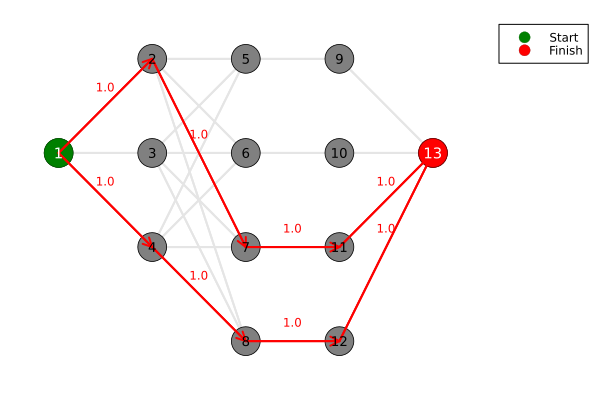

In [66]:
let

    # initialize -
    capacity = model₂.capacity; # get the capacity dictionary
    flow_dictionary = flow₂;
    base_graphmodel = model₂;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go
    path_edges = keys(flow); # this is a dictionary of (u,v) → flow_value

    # draw -
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Finish")

    # plot the flow path -
    for ((s,t),flow_value) ∈ flow_dictionary
       
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:red, lw=2, label="")
        
        # annotate the path-edge weight in red slightly above the red edge
        mwx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        mwy = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        w = round(flow_dictionary[(s,t)], digits=2)
        annotate!(mwx, mwy + 0.20, text(string(w), 8, :red))
    end

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

When we block all outflow from node `3` [the `maximumflow(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/graphs/#VLDataScienceMachineLearningPackage.maximumflow) either reroutes flow through other workers (if capacities and edges allow) or the total maximum flow decreases. 

In the plot you'll notice red edges that previously left node `3` disappear and alternate paths appear if available. Comparing the numeric maximum flow values before and after the block quantifies how important node `3` was to meeting demand.

In [40]:
println("Max default: $(m), case 1: $(m₁) versus case 3: $(m₂)")

Max default: 3.0, case 1: 4.0 versus case 3: 2.0


Blocking flow through node `3` decreases the overall maximum flow in the network (thus, node `3` is important!)

___

## Summary
In this lab, we explored the Ford-Fulkerson method for computing maximum flow in a directed graph. We built a bipartite-like flow network representing workers and tasks, computed the maximum flow using the Ford-Fulkerson method, and visualized the flow paths.

> **Key takeaways:**
> * **Flow networks model real-world allocation problems.** We represented worker-task assignments as a flow network where edge capacities determine how much work each worker can handle.
> * **The Ford-Fulkerson algorithm finds optimal flow distribution.** This method  computes the best way to route flow from source to sink while respecting all capacity constraints.
> * **Capacity changes reveal network bottlenecks.** Increasing edge capacity only improves total flow if that edge was actually limiting performance, while blocking key nodes can significantly reduce overall system capacity.

__Where do we go from here?__ The maximum flow problem is interesting, but it has a more (IMHO) interesting related problem: the minimum cost maximum flow problem. In this problem, we want to not only maximize the flow through the network, but also minimize the cost of that flow. 

This is a more complex problem, but it has many real-world applications, such as supply chain management and transportation. We are going to explore this problem in the context of linear programming in future lectures and labs.
___